### Load LLM

In [1]:
%pip install --quiet -U langchain-ollama

Note: you may need to restart the kernel to use updated packages.


In [2]:
from langchain_ollama.chat_models import ChatOllama

local_llm = "llama3.2:1b-instruct-fp16"
llm = ChatOllama(
    base_url="http://localhost:11434",
    model = local_llm,
    # temperature = 0.8,
    # num_predict = 256,
    # format="json",
    # other params ...
)

messages = [
    ("system", "You are a helpful translator. Translate the user sentence to French."),
    ("human", "I love programming."),
]
llm.invoke(messages)

AIMessage(content='Vous aimez programmmer.', additional_kwargs={}, response_metadata={'model': 'llama3.2:1b-instruct-fp16', 'created_at': '2025-04-15T03:54:58.4678672Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1125564400, 'load_duration': 18841600, 'prompt_eval_count': 42, 'prompt_eval_duration': 584000000, 'eval_count': 7, 'eval_duration': 224000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None), 'model_name': 'llama3.2:1b-instruct-fp16'}, id='run-8f724c77-bc45-4c93-bfe5-588a454b2a97-0', usage_metadata={'input_tokens': 42, 'output_tokens': 7, 'total_tokens': 49})

### Load Embedding and Vector Store

In [3]:
%pip install --quiet -U langchain-ollama

Note: you may need to restart the kernel to use updated packages.


In [4]:
from langchain_ollama import OllamaEmbeddings
from langchain.vectorstores import Chroma

# Initialize the Nomic embedding model
embeddings = OllamaEmbeddings(
    base_url="http://localhost:11434",
    model="nomic-embed-text"
)

vector_store = Chroma(
    collection_name="example_collection",
    embedding_function=embeddings,
    persist_directory="./chroma_langchain_db",  # Where to save data locally, remove if not necessary
)

C:\Users\Jessy\AppData\Local\Temp\ipykernel_14560\4149793632.py:10: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vector_store = Chroma(


### Load Documents (External Data Source)

In [5]:
%pip install --quiet -U langchain-community

Note: you may need to restart the kernel to use updated packages.


In [6]:
import bs4
from langchain_community.document_loaders import WebBaseLoader


# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

print(f"Total characters: {len(docs[0].page_content)}")

USER_AGENT environment variable not set, consider setting it to identify your requests.


Total characters: 43130


### Indexing: Chunk Documents

In [7]:
%pip install --quiet -U langchain-text-splitters

Note: you may need to restart the kernel to use updated packages.


In [8]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

# Index chunks
vdb_doc_ids = vector_store.add_documents(documents=all_splits)

print(vdb_doc_ids[:3])

['addc111e-7274-4e9a-83cb-58b256ea0228', 'bf94dba4-63a8-4af5-a247-fb0f3d4f4111', 'd2cd280d-9430-45ee-8f68-f919b11f7cff']


### LangGraph Assemble the Retrieval and Generation Step into RAG Application

In [9]:
from langchain_core.prompts import PromptTemplate

template = """
You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:
"""

# Define prompt for question-answering
prompt = PromptTemplate.from_template(template)

In [10]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict

# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [11]:
%pip install --quiet -U langgraph

Note: you may need to restart the kernel to use updated packages.


In [12]:
from langgraph.graph import START, StateGraph

# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

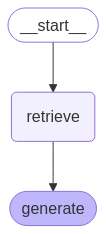

In [13]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
response = graph.invoke({"question": "What is Task Decomposition?"})
print(f'Answer: {response["answer"]}')

Answer: Task Decomposition is a technique used by LLM-powered autonomous agent systems to break down complicated tasks into smaller, simpler steps for more efficient and effective processing.

Here's an example of how Task Decomposition works:

1.  The task is broken down into smaller components, like planning ahead.
2.  Each component is executed using specialized models, such as expert models that execute specific tasks on the user input data.
3.  Inference results are analyzed by each model to understand its processing steps and provide insights into the task's complexity.

In this example, User Input - Plan Tasks, Model Selection - Choose Expert Models, Task Execution - Execute Tasks on User Input Data, and Analysis - Understand Inference Results.
